# 02: Production
Taking football classifier from previous exercise, improving it and putting it into production.

Can see app live [here on hugging face](https://huggingface.co/spaces/mojodojodev/football-classifier) and here's the iframe:

<iframe
	src="https://mojodojodev-football-classifier.hf.space"
	frameborder="0"
	width="850"
	height="550"
></iframe>

## Setup
Import fastbook and patch IPython for VS Code

In [1]:
from fastbook import *
from fastai.vision.widgets import * 
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

Use the same dataset from previous exercise

In [2]:
data_path = Path('data')/'01'
data_path.mkdir(parents=True,exist_ok=True)

## Download Dataset

In [3]:
searches = "rugby","afl","nfl","soccer"
dataset_path = data_path/"datasets"

## Build Data Block

In [4]:
failed = verify_images(get_image_files(dataset_path))
failed.map(Path.unlink)

(#0) []

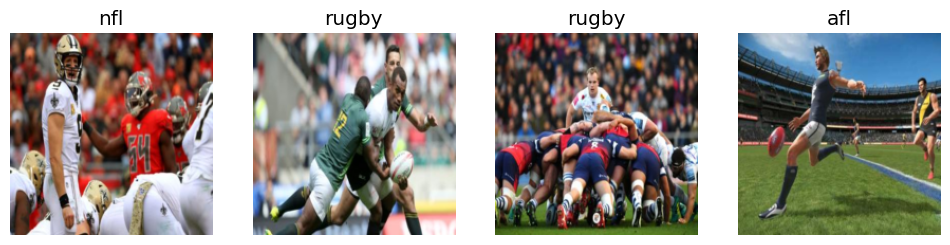

In [5]:
football = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

dls = football.dataloaders(dataset_path)
dls.valid.show_batch(max_n=4, nrows=1)

## Augment Images

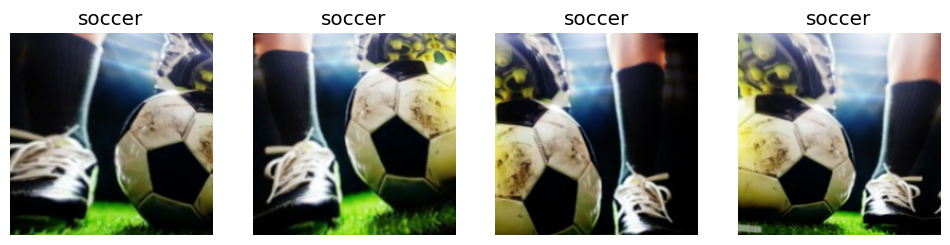

In [6]:
football = football.new(
    item_tfms=RandomResizedCrop(192, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = football.dataloaders(dataset_path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.892716,1.607285,0.551724,00:00
1,1.783888,1.293517,0.448276,00:00
2,1.553403,1.101768,0.396552,00:00
3,1.386793,1.080031,0.344828,00:00
4,1.214310,1.075227,0.327586,00:00
5,1.076431,1.076623,0.310345,00:00
6,0.965085,1.075264,0.275862,00:00
7,0.882993,1.080741,0.258621,00:00


## Confusion Matrix

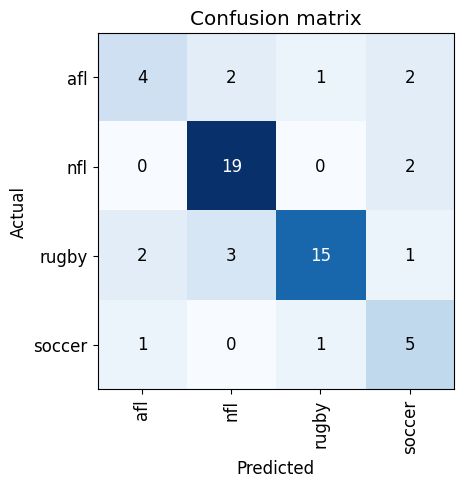

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Show examples of what's causing problems

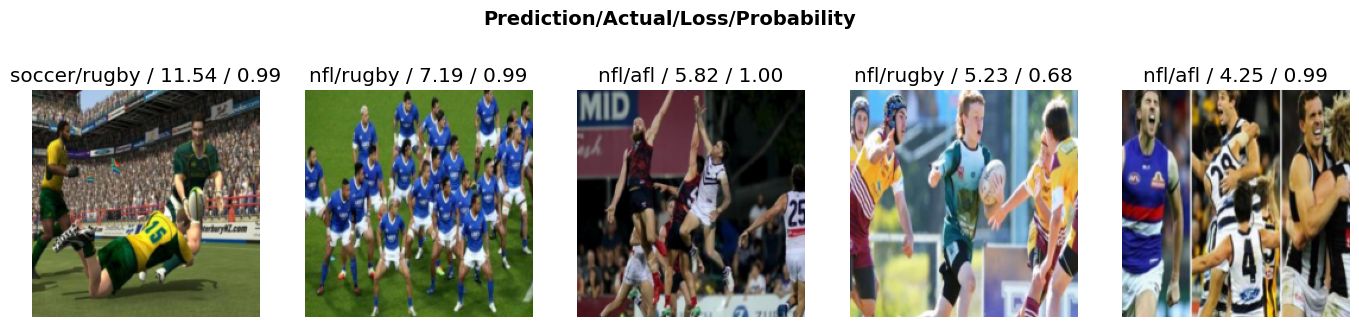

In [9]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [10]:
sport,_,probs = learn.predict(PILImage.create(data_path/'nfl.jpg'))
print(f"this is {sport}")
print("\n--probabilities--")
for i, o in enumerate(dls.vocab):
    print(f"{o}: {probs[i]:.4f}")

this is nfl

--probabilities--
afl: 0.0000
nfl: 1.0000
rugby: 0.0000
soccer: 0.0000


## Export the model

In [14]:
learn.export("football-classifier/model.pkl")
learn.export("model.pkl")

## Build script to put it into production on HuggingFace

In [ ]:
#|default_exp app

In [12]:
#|export
from fastai.vision.all import *
import gradio as gr

In [15]:
#|export
learn = load_learner('model.pkl')

In [16]:
#|export
categories = ('afl', 'nfl', 'rugby', 'soccer')

def classify_image(img):
    _,_,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

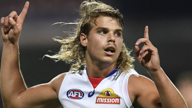

In [17]:
im = PILImage.create('data/01/afl.jpg')
im.thumbnail((192,192))
im

In [18]:
classify_image(im)

{'afl': 0.9970560073852539,
 'nfl': 0.0002015349455177784,
 'rugby': 0.0019157134229317307,
 'soccer': 0.0008266967488452792}

In [25]:
#|export
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = [f'data/01/{i}.jpg' for i in categories]

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/home/j/src/fastai-course/.venv/lib/python3.11/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/home/j/src/fastai-course/.venv/lib/python3.11/site-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/home/j/src/fastai-course/.venv/lib/python3.11/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/j/src/fastai-course/.venv/lib/python3.11/site-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Export the script ready to push to Hugging Face

In [27]:
from nbdev import export

export.nb_export('02-exercise.ipynb', 'football-classifier')